Installing required packages

In [23]:
!pip install scikit-optimize

Importing the Dependencies

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical

Data Collection and Pre-processing

In [25]:
# importing the dataset to Pandas Dataframe
dataset = pd.read_csv("/content/airline-passengers.csv",usecols=[1],engine='python')
dataset.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [26]:
# no. of rows and columns
dataset.shape

(144, 1)

In [27]:
# checking empty values in dataset
dataset.isnull().sum()

,0
Passengers,0


In [28]:
# converting dataset to numpy array
dataset = dataset.values.astype('int32')
print(type(dataset))

<class 'numpy.ndarray'>


In [29]:
dataset

array([[112],
       [118],
       [132],
       [129],
       [121],
       [135],
       [148],
       [148],
       [136],
       [119],
       [104],
       [118],
       [115],
       [126],
       [141],
       [135],
       [125],
       [149],
       [170],
       [170],
       [158],
       [133],
       [114],
       [140],
       [145],
       [150],
       [178],
       [163],
       [172],
       [178],
       [199],
       [199],
       [184],
       [162],
       [146],
       [166],
       [171],
       [180],
       [193],
       [181],
       [183],
       [218],
       [230],
       [242],
       [209],
       [191],
       [172],
       [194],
       [196],
       [196],
       [236],
       [235],
       [229],
       [243],
       [264],
       [272],
       [237],
       [211],
       [180],
       [201],
       [204],
       [188],
       [235],
       [227],
       [234],
       [264],
       [302],
       [293],
       [259],
       [229],
       [203],
      

Data Scaling

In [30]:
# Scaling the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

Data Splitting

In [31]:
# Splitting the data into train data and test data
train, test = train_test_split(dataset, test_size=0.33, shuffle=False)
print("Training data: ",train)
print("Testing data: ",test)

Training data:  [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]
 [0.04247104]
 [0.07142857]
 [0.05984556]
 [0.04054054]
 [0.08687259]
 [0.12741313]
 [0.12741313]
 [0.1042471 ]
 [0.05598456]
 [0.01930502]
 [0.06949807]
 [0.07915058]
 [0.08880309]
 [0.14285714]
 [0.11389961]
 [0.13127413]
 [0.14285714]
 [0.18339768]
 [0.18339768]
 [0.15444015]
 [0.11196911]
 [0.08108108]
 [0.11969112]
 [0.12934363]
 [0.14671815]
 [0.17181467]
 [0.14864865]
 [0.15250965]
 [0.22007722]
 [0.24324324]
 [0.26640927]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374517]
 [0.17760618]
 [0.17760618]
 [0.25482625]
 [0.25289575]
 [0.24131274]
 [0.26833977]
 [0.30888031]
 [0.32432432]
 [0.25675676]
 [0.20656371]
 [0.14671815]
 [0.18725869]
 [0.19305019]
 [0.16216216]
 [0.25289575]
 [0.23745174]
 [0.25096525]
 [0.30888031]
 [0.38223938]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.

Function to create 2 numpy arrays:



*   dataX which stores the past look_back no. of values
*   dataY which stores the next value



In [32]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)

Building LSTM Model

In [33]:
def build_lstm_model(units=50, look_back=1, optimizer='adam', learning_rate=0.001, loss='mse'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, look_back)))
    model.add(Dense(1))

    if optimizer=='adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer=='sgd':
        opt = SGD(learning_rate=learning_rate)

    model.compile(loss=loss, optimizer=opt)
    return model

The evaluate_model function trains an LSTM with given hyperparameters on the training data, predicts on the test data, and returns the model’s RMSE as a measure of performance.

In [34]:
def evaluate_model(units, batch_size, epochs, optimizer, look_back, learning_rate):
    trainX, trainY = create_dataset(train, look_back)
    testX, testY   = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX  = np.reshape(testX,  (testX.shape[0], 1, testX.shape[1]))

    model = build_lstm_model(units, look_back, optimizer, learning_rate, loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    model.fit(trainX, trainY,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(testX, testY),
              verbose=0,
              callbacks=[early_stop])

    testPredict = model.predict(testX, verbose=0)
    testPredict = scaler.inverse_transform(testPredict)
    testY_rescaled = scaler.inverse_transform([testY])
    rmse = np.sqrt(mean_squared_error(testY_rescaled[0], testPredict[:,0]))

    return rmse

In [45]:
# defining the search space for Bayesian Optimization
search_space = [
    Integer(4, 128, name='units'),
    Integer(1, 32, name='batch_size'),
    Integer(20, 100, name='epochs'),
    Categorical(['adam', 'rmsprop', 'sgd'], name='optimizer'),
    Integer(1, 5, name='look_back'),
    Real(1e-4, 3e-3, "log-uniform", name='learning_rate')
]

The objective function evaluates a set of hyperparameters by training the LSTM model and returning its RMSE and also logging the results to the CSV file.


In [42]:
def objective(params):
    units, batch_size, epochs, optimizer, look_back, learning_rate = params

    units = int(units)
    batch_size = int(batch_size)
    epochs = int(epochs)
    look_back = int(look_back)

    rmse = evaluate_model(
        units=units,
        batch_size=batch_size,
        epochs=epochs,
        optimizer=optimizer,
        look_back=look_back,
        learning_rate=learning_rate
    )
    print(f"Params: units={units}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}, look_back={look_back}, lr={learning_rate:.5f} -> RMSE={rmse:.2f}")

    # Log this trial
    writer.writerow([units, batch_size, epochs, optimizer, look_back, learning_rate, rmse])
    f.flush()
    return rmse


Run Bayesian Optimization using gp_minimize while appending each trial's hyperparameters and RMSE to the CSV file.

In [47]:
csv_file = 'bayesian_trials.csv'
f = open(csv_file, 'a', newline='')
writer = csv.writer(f)

result = gp_minimize(
    func=objective,
    dimensions=search_space,
    acq_func='EI',
    n_calls=20,
    random_state=1
)

f.close()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=128, batch_size=30, epochs=30, optimizer=sgd, look_back=2, lr=0.00039 -> RMSE=293.68


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=52, batch_size=22, epochs=95, optimizer=sgd, look_back=2, lr=0.00060 -> RMSE=281.28


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=59, batch_size=8, epochs=63, optimizer=sgd, look_back=3, lr=0.00043 -> RMSE=257.96


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=120, batch_size=25, epochs=77, optimizer=sgd, look_back=1, lr=0.00058 -> RMSE=290.38


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=111, batch_size=27, epochs=86, optimizer=adam, look_back=1, lr=0.00098 -> RMSE=50.00


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=78, batch_size=22, epochs=53, optimizer=adam, look_back=2, lr=0.00016 -> RMSE=173.17


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=101, batch_size=14, epochs=23, optimizer=rmsprop, look_back=4, lr=0.00028 -> RMSE=116.80


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=59, batch_size=8, epochs=26, optimizer=rmsprop, look_back=1, lr=0.00216 -> RMSE=51.34


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=19, batch_size=17, epochs=27, optimizer=sgd, look_back=5, lr=0.00028 -> RMSE=341.78


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=76, batch_size=19, epochs=69, optimizer=sgd, look_back=2, lr=0.00022 -> RMSE=292.51


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=128, batch_size=32, epochs=100, optimizer=adam, look_back=3, lr=0.00179 -> RMSE=105.16


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=128, batch_size=1, epochs=20, optimizer=rmsprop, look_back=1, lr=0.00103 -> RMSE=52.80


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=4, batch_size=32, epochs=100, optimizer=adam, look_back=5, lr=0.00300 -> RMSE=62.27


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=4, batch_size=1, epochs=20, optimizer=rmsprop, look_back=1, lr=0.00300 -> RMSE=54.12


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=128, batch_size=32, epochs=100, optimizer=rmsprop, look_back=2, lr=0.00010 -> RMSE=156.37


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(4), np.int64(1), np.int64(20), np.str_('rmsprop'), np.int64(1), 0.003] before, using random point [np.int64(32), np.int64(18), np.int64(55), 'adam', np.int64(2), 0.000736148247663639]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=32, batch_size=18, epochs=55, optimizer=adam, look_back=2, lr=0.00074 -> RMSE=73.62


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(4), np.int64(1), np.int64(20), np.str_('rmsprop'), np.int64(1), 0.003] before, using random point [np.int64(98), np.int64(15), np.int64(63), 'rmsprop', np.int64(4), 0.00010030674340356781]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=98, batch_size=15, epochs=63, optimizer=rmsprop, look_back=4, lr=0.00010 -> RMSE=116.65


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(4), np.int64(1), np.int64(20), np.str_('rmsprop'), np.int64(1), 0.003] before, using random point [np.int64(15), np.int64(12), np.int64(25), 'rmsprop', np.int64(3), 0.001790699552071994]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=15, batch_size=12, epochs=25, optimizer=rmsprop, look_back=3, lr=0.00179 -> RMSE=72.14


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=128, batch_size=1, epochs=20, optimizer=rmsprop, look_back=5, lr=0.00300 -> RMSE=55.91


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: units=128, batch_size=1, epochs=100, optimizer=rmsprop, look_back=1, lr=0.00300 -> RMSE=55.94


Extracting best hyperparameters obtained and casting them back to python int

In [50]:
best_units, best_batch_size, best_epochs, best_optimizer, best_look_back, best_lr = result.x
best_units, best_batch_size, best_epochs, best_look_back = map(int, [best_units, best_batch_size, best_epochs, best_look_back])
best_lr = float(best_lr)

print("\nBest Hyperparameters found:")
print(f"Units: {best_units}")
print(f"Batch Size: {best_batch_size}")
print(f"Epochs: {best_epochs}")
print(f"Optimizer: {best_optimizer}")
print(f"Look Back: {best_look_back}")
print(f"Learning Rate: {best_lr:.5f}")


Best Hyperparameters found:
Units: 111
Batch Size: 27
Epochs: 86
Optimizer: adam
Look Back: 1
Learning Rate: 0.00098


Building the LSTM model with selected hyperparameters

In [55]:
best_model = build_lstm_model(units=best_units,
                              look_back=best_look_back,
                              optimizer=best_optimizer,
                              learning_rate=best_lr,
                              loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the LSTM model

In [56]:
trainX, trainY = create_dataset(train, best_look_back)
testX, testY   = create_dataset(test, best_look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX,  (testX.shape[0], 1, testX.shape[1]))


early_stop = EarlyStopping(monitor='val_loss', patience=5)
best_model.fit(trainX, trainY,
               epochs=best_epochs,
               batch_size=best_batch_size,
               validation_data=(testX, testY),
               verbose=2,
               callbacks=[early_stop])

Epoch 1/86
4/4 - 1s - 351ms/step - loss: 0.0609 - val_loss: 0.3502
Epoch 2/86
4/4 - 0s - 26ms/step - loss: 0.0528 - val_loss: 0.3205
Epoch 3/86
4/4 - 0s - 17ms/step - loss: 0.0454 - val_loss: 0.2923
Epoch 4/86
4/4 - 0s - 18ms/step - loss: 0.0389 - val_loss: 0.2657
Epoch 5/86
4/4 - 0s - 35ms/step - loss: 0.0331 - val_loss: 0.2406
Epoch 6/86
4/4 - 0s - 20ms/step - loss: 0.0281 - val_loss: 0.2170
Epoch 7/86
4/4 - 0s - 34ms/step - loss: 0.0238 - val_loss: 0.1951
Epoch 8/86
4/4 - 0s - 22ms/step - loss: 0.0202 - val_loss: 0.1750
Epoch 9/86
4/4 - 0s - 36ms/step - loss: 0.0175 - val_loss: 0.1569
Epoch 10/86
4/4 - 0s - 37ms/step - loss: 0.0154 - val_loss: 0.1411
Epoch 11/86
4/4 - 0s - 33ms/step - loss: 0.0139 - val_loss: 0.1277
Epoch 12/86
4/4 - 0s - 45ms/step - loss: 0.0129 - val_loss: 0.1167
Epoch 13/86
4/4 - 0s - 33ms/step - loss: 0.0123 - val_loss: 0.1081
Epoch 14/86
4/4 - 0s - 33ms/step - loss: 0.0119 - val_loss: 0.1016
Epoch 15/86
4/4 - 0s - 38ms/step - loss: 0.0116 - val_loss: 0.0971
Epo

Evaluation and Visualization

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


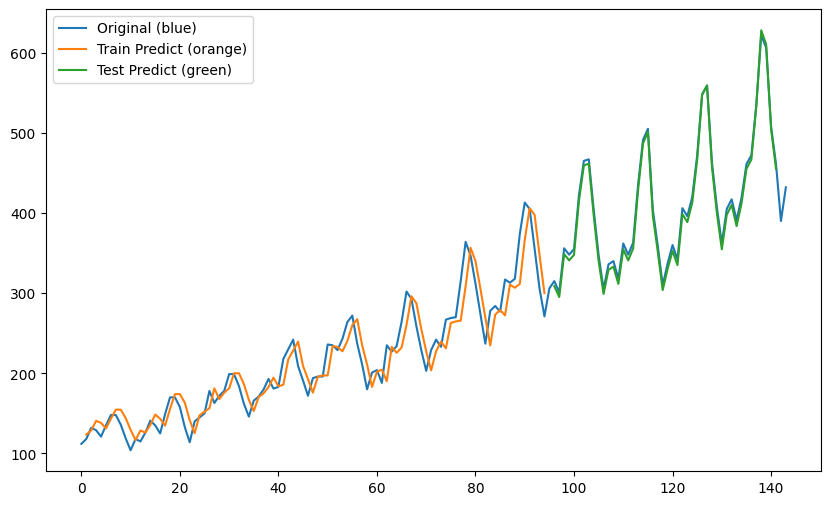

In [57]:
trainPredict = best_model.predict(trainX)
testPredict  = best_model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY_rescaled = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_rescaled = scaler.inverse_transform([testY])

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[best_look_back:len(trainPredict)+best_look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(best_look_back*2):len(trainPredict)+(best_look_back*2)+len(testPredict), :] = testPredict

plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset), label="Original (blue)")
plt.plot(trainPredictPlot, label="Train Predict (orange)")
plt.plot(testPredictPlot, label="Test Predict (green)")
plt.legend()
plt.show()